# Visualisation of the Prediction Depth of CIFAR-10

### - Read output from `get_pd`

In [1]:
import os
import json

def read_avg_files(directory: str, train=True):
    """
    This function reads the avg.json file from the directory
    :param directory:
    :param train: True if we wants train_avg.json, False if we wants test_avg.json
    :return:
    """
    file_list = os.listdir(directory)
    if train:
        json_files = [file for file in file_list if file.endswith("train_avg.json")]
    else:
        json_files = [file for file in file_list if file.endswith("test_avg.json")]

    if len(json_files) == 0:
        raise FileNotFoundError("No {}avg.json file found in the directory".format("train" if train else "test"))
    elif len(json_files) > 1:
        raise FileExistsError("More than one {}avg.json file found in the directory".format("train" if train else "test"))
    else:
        with open(os.path.join(directory, json_files[0]), "r") as f:
            avg_dict = json.load(f)

    return avg_dict


il_dict_train = read_avg_files(os.path.join(os.getcwd(), "il_results", "avg"), train=True)
il_dict_test = read_avg_files(os.path.join(os.getcwd(), "il_results", "avg"), train=False)

### - Link `il_dict` to `cifar10` dataset

In [2]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import PILToTensor
import matplotlib.pyplot as plt

cifartargets = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']

class CIFAR10PD(CIFAR10):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CIFAR10PD, self).__init__(root, train, transform, target_transform, download)

    def __getitem__(self, index):
        # to get (img, target), index
        img, target = super(CIFAR10PD, self).__getitem__(index)
        return PILToTensor()(img), target, index
trainset = CIFAR10PD('./', train=False, download=True)
testset = CIFAR10PD('./', train=True, download=True)

dataloader_train = DataLoader(trainset, batch_size=1, shuffle=False)
dataloader_test = DataLoader(testset, batch_size=1, shuffle=False)

CIFAR_dict_train = {}
CIFAR_dict_test = {}

for imgs, targets, indexes in dataloader_train:
    for img, target, index in zip(imgs, targets, indexes):
        CIFAR_dict_train[index.item()] = (img, target)

for imgs, targets, indexes in dataloader_test:
    for img, target, index in zip(imgs, targets, indexes):
        CIFAR_dict_test[index.item()] = (img, target)

Files already downloaded and verified
Files already downloaded and verified


### - split the unlearned images and learned images

In [3]:
learned_il_dict_train = {}
unlearned_il_dict_train = {}
learned_il_dict_test = {}
unlearned_il_dict_test = {}

for index, score in il_dict_train.items():
    if score == -1:
        learned_il_dict_train[index] = -1
    else:
        learned_il_dict_train[index] = score

for index, score in il_dict_test.items():
    if score == -1:
        learned_il_dict_test[index] = -1
    else:
        learned_il_dict_test[index] = score

def imgHardnessLink(img_dict: dict, hardness_dict:dict) -> dict:
    """
    This function gives each image its hardness score
    @param img_dict: dictionary of image in the format of {index : (img, target)}
    @param pd_dict: dictionary of image in the format of {index : PD score}
    @return: dictionary of {img : (target, PD score, index)}
    """

    # type checking to make sure the key is int
    type_check = [type(k) for k in img_dict.keys()]
    if not all([t == int for t in type_check]):
        new_dict = {}
        for k, v in img_dict.items():
            new_dict[int(k)] = v
        img_dict = new_dict

    type_check = [type(k) for k in hardness_dict.keys()]
    if not all([t == int for t in type_check]):
        new_dict = {}
        for k, v in hardness_dict.items():
            new_dict[int(k)] = v
        hardness_dict = new_dict

    img_hardness_dict = {}
    for index in (set(hardness_dict.keys()).intersection(set(img_dict.keys()))):
        # image -> (image_target, score, index)
        img_hardness_dict[img_dict[index][0]] = (img_dict[index][1].item(), hardness_dict[index], index)
    return img_hardness_dict


learned_img_IL_dict_train = imgHardnessLink(CIFAR_dict_train, learned_il_dict_train)
unlearned_il_dict_train = imgHardnessLink(CIFAR_dict_train, unlearned_il_dict_train)
learned_img_IL_dict_test = imgHardnessLink(CIFAR_dict_test, learned_il_dict_test)
unlearned_il_dict_test = imgHardnessLink(CIFAR_dict_test, unlearned_il_dict_test)

# Compare Prediction Depth with Iteration Learned (train set)

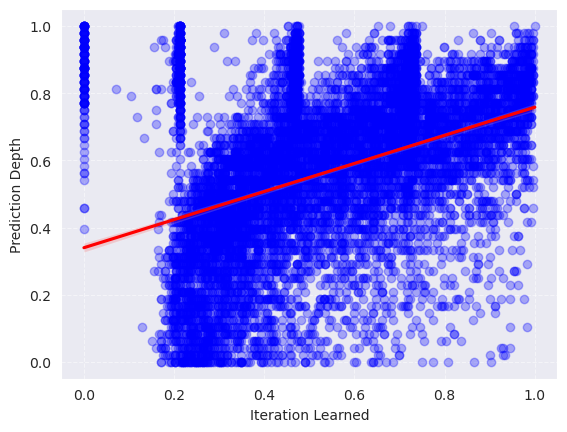

Pearson's correlation coefficient: 0.3994597170008023
p-value: 0.0


In [4]:
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


pd_avg_dict_train = read_avg_files('./pd_results/avg', train=True)

imgPD_dict = imgHardnessLink(CIFAR_dict_train, pd_avg_dict_train)
imgIL_dict = imgHardnessLink(CIFAR_dict_train, il_dict_train)

# relabel all -1 (unlearned) example to 10
il_dict_all = {}
for key, (img, score, index) in imgIL_dict.items():
    if score == -1:
        il_dict_all[key] = (img, 10, index)
    else:
        il_dict_all[key] = (img, score, index)

common_keys = set(imgPD_dict.keys()).intersection(il_dict_all.keys())

# Creating lists of scores from il_dict_all and imgPD_dict for common keys
score_il = []
score_pd = []
for key in common_keys:
    score_il.append(il_dict_all[key][1])
    score_pd.append(imgPD_dict[key][1])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Reshape the scores to be 2D arrays
score_il_2d = np.array(score_il).reshape(-1, 1)
score_pd_2d = np.array(score_pd).reshape(-1, 1)

# Apply MinMaxScaler
score_il_scaled = scaler.fit_transform(score_il_2d).flatten()
score_pd_scaled = scaler.fit_transform(score_pd_2d).flatten()

# Calculating the Pearson's correlation coefficient and p-value using normalized scores
correlation, p_value = pearsonr(score_il_scaled, score_pd_scaled)

# Plotting the scatter plot
sns.regplot(x=score_il_scaled, y=score_pd_scaled, scatter_kws={"color": "blue", "alpha": 0.3}, line_kws={"color": "red"})

# Adding labels and grid to the plot
plt.xlabel("Iteration Learned")
plt.ylabel("Prediction Depth")
plt.grid(True, linestyle='--', alpha=0.5)

# Displaying the plot
plt.show()

# Printing the correlation coefficient and p-value
print("Pearson's correlation coefficient:", correlation)
print("p-value:", p_value)

# Compare Iteration Learned with C-score (train set)

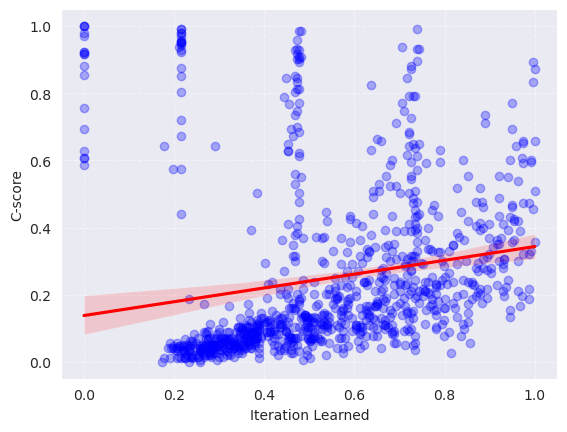

Pearson's correlation coefficient: 0.18798512388980737
p-value: 5.264432144978018e-09


In [5]:
cs_avg_dict_train = read_avg_files('./cs_results', train=True)

imgCS_dict = imgHardnessLink(CIFAR_dict_train, cs_avg_dict_train)

common_keys = set(imgCS_dict.keys()).intersection(il_dict_all.keys())

score_cs = []
score_il = []
for key in common_keys:
    score_cs.append(1-imgCS_dict[key][1])
    score_il.append(il_dict_all[key][1])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Reshape the scores to be 2D arrays
score_cs_2d = np.array(score_cs).reshape(-1, 1)
score_il_2d = np.array(score_il).reshape(-1, 1)

# Apply MinMaxScaler
score_cs_scaled = scaler.fit_transform(score_cs_2d).flatten()
score_il_scaled = scaler.fit_transform(score_il_2d).flatten()

# Calculating the Pearson's correlation coefficient and p-value using normalized scores
correlation, p_value = pearsonr(score_il_scaled, score_cs_scaled)

# Plotting the scatter plot
sns.regplot(x=score_il_scaled, y=score_cs_scaled, scatter_kws={"color": "blue", "alpha": 0.3}, line_kws={"color": "red"})
plt.xlabel("Iteration Learned")
plt.ylabel("C-score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Printing the correlation coefficient and p-value
print("Pearson's correlation coefficient:", correlation)
print("p-value:", p_value)

# Compare Prediction Depth with C-score (train set)

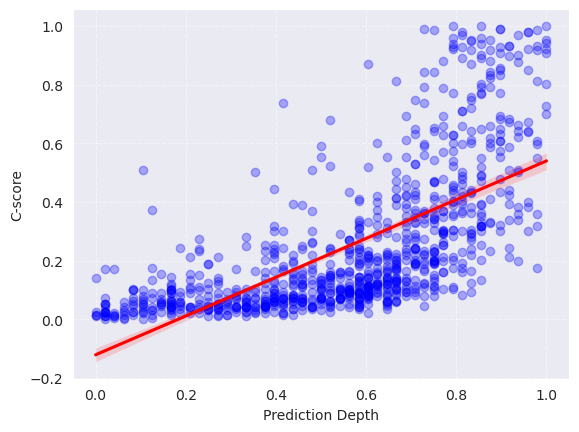

Pearson's correlation coefficient: 0.6597030756691895
p-value: 9.740784672121078e-120


In [6]:
common_keys = set(imgCS_dict.keys()).intersection(imgPD_dict.keys())

score_cs = []
score_pd = []
for key in common_keys:
    score_cs.append(1-imgCS_dict[key][1])
    score_pd.append(imgPD_dict[key][1])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Reshape the scores to be 2D arrays
score_cs_2d = np.array(score_cs).reshape(-1, 1)
score_pd_2d = np.array(score_pd).reshape(-1, 1)

# Apply MinMaxScaler
score_cs_scaled = scaler.fit_transform(score_cs_2d).flatten()
score_pd_scaled = scaler.fit_transform(score_pd_2d).flatten()

# Calculating the Pearson's correlation coefficient and p-value using normalized scores
correlation, p_value = pearsonr(score_pd_scaled, score_cs_scaled)

# Plotting the scatter plot
sns.regplot(x=score_pd_scaled, y=score_cs_scaled, scatter_kws={"color": "blue", "alpha": 0.3}, line_kws={"color": "red"})
plt.xlabel("Prediction Depth")
plt.ylabel("C-score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Printing the correlation coefficient and p-value
print("Pearson's correlation coefficient:", correlation)
print("p-value:", p_value)

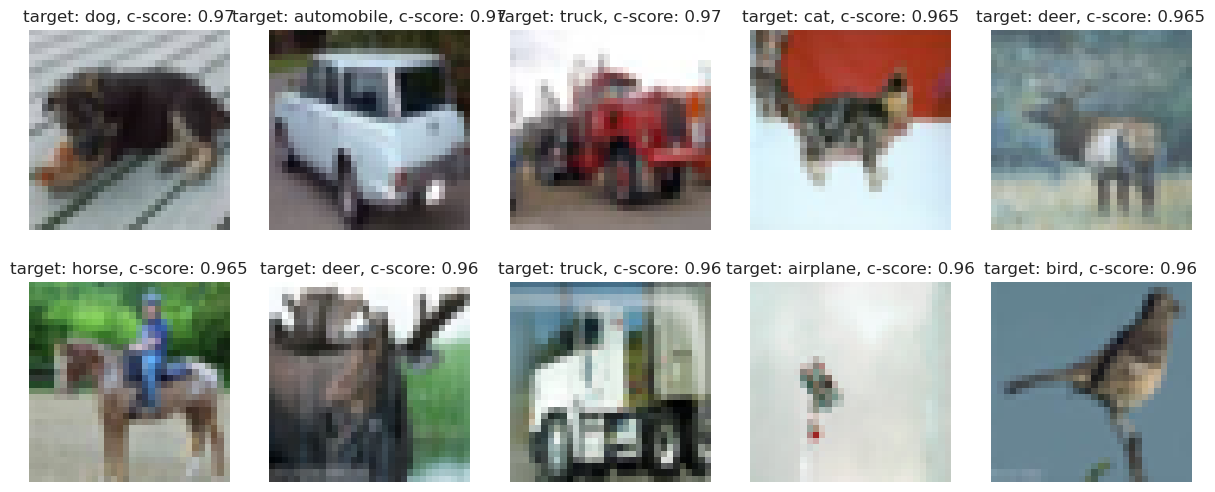

In [7]:
# plot image with highest c-score
import matplotlib.pyplot as plt
import numpy as np

# find the 10 hardest examples(), imgCS_dict[image] -> (target, c-score, index)
hardest_examples = sorted(imgCS_dict.items(), key=lambda x: x[1][1], reverse=True)[:10]

# plot the hardest examples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, (img, (target, cs, index)) in enumerate(hardest_examples):
    axes[i//5, i%5].imshow(img.permute(1, 2, 0))
    axes[i//5, i%5].set_title("target: {}, c-score: {}".format(cifartargets[target], cs))
    axes[i//5, i%5].axis('off')
plt.show()

2023-08-06 08:20:22.803476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-06 08:20:24.006357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-06 08:20:24.006963: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


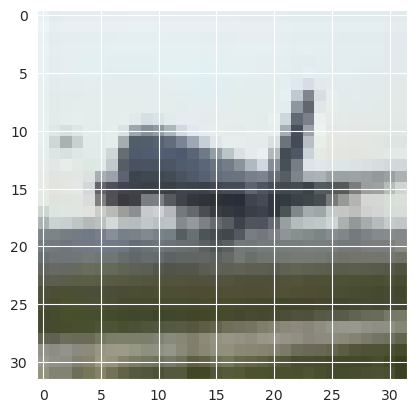

In [8]:
import numpy as np
import tensorflow_datasets as tfds
# load the full cifar10 dataset into memory to get the example ids
raw_data, info = tfds.load(name='cifar10', batch_size=-1, with_info=True,
                           as_dataset_kwargs={'shuffle_files': False})
raw_data = tfds.as_numpy(raw_data)
trainset_np, testset_np = raw_data['train'], raw_data['test']

# load c-scores in original data order
cscore_fn = 'cifar10-cscores-orig-order.npz'
cscore_arrays = np.load(cscore_fn)

# get example index
def _id_to_idx(str_id):
  return int(str_id.split(b'_')[1])
vec_id_to_idx = np.vectorize(_id_to_idx)
trainset_orig_idx = vec_id_to_idx(trainset_np['id'])

# sanity check with labels to make sure that data order is correct
assert np.all(trainset_np['label'] == cscore_arrays['labels'][trainset_orig_idx])

# plot the id=1198 image in trainset
plt.imshow(trainset_np['image'][1198])

# now this is c-scores in TFDS order
ordered_cscores = cscore_arrays['scores'][trainset_orig_idx]